In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import pyccl as ccl
import matplotlib.pylab as plt

# jax cosmo
from jax_cosmo.core import Cosmology
from jax_cosmo.power import linear_matter_power, nonlinear_matter_power
import jax_cosmo.power as jcp

# the emulator part
from jax_cosmo.power import linear_matter_power_emu

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 12

In [3]:
cosmo_jax = Cosmology(Omega_c=0.25,
                      Omega_b=0.05,
                      h=0.7,
                      sigma8 = 0.8,
                      n_s=0.96,
                      Omega_k=0.,
                      w0=-1.,
                      wa=0.,
                     Neff = 3.044)

cosmo_ccl = ccl.Cosmology(Omega_c=0.25,
                          Omega_b=0.05,
                          h=0.7,
                          sigma8 = 0.8,
                          n_s=0.96,
                          Neff = 3.044,
                          transfer_function='eisenstein_hu',
                          matter_power_spectrum='halofit')

In [3]:
wavenumbers = jnp.geomspace(1E-4, 50, 500)
scalefactor = 1.0

In [ ]:
@jax.jit
def jax_linear_pk_emu(cosmology, wavenumbers, scalefactor):
    """
    JAXCOSMO outputs the power spectrum in a different unit. So we scale by h^3 for the power and h for the wavenumbers.
    """
    pk_jax = linear_matter_power_emu(cosmology, wavenumbers / cosmology.h, a=scalefactor) / cosmology.h**3
    return pk_jax


@jax.jit
def jax_linear_pk_eh(cosmology, wavenumbers, scalefactor):
    """
    JAXCOSMO outputs the power spectrum in a different unit. So we scale by h^3 for the power and h for the wavenumbers.
    """
    pk_jax = linear_matter_power(cosmology, wavenumbers / cosmology.h, a=scalefactor) / cosmology.h**3
    return pk_jax


In [5]:
jcp.USE_EMU = True
pk_jax_emu = jax_linear_pk_emu(cosmo_jax, wavenumbers, scalefactor)

jcp.USE_EMU = False
pk_jax_eh = jax_linear_pk_eh(cosmo_jax, wavenumbers, scalefactor)

## Linear Matter Power Spectrum


In [ ]:
# In CCL Wavenumber is in Mpc^-1 and returns the power spectrum in Mpc^3
pk_ccl = ccl.linear_matter_power(cosmo_ccl, wavenumbers, scalefactor)

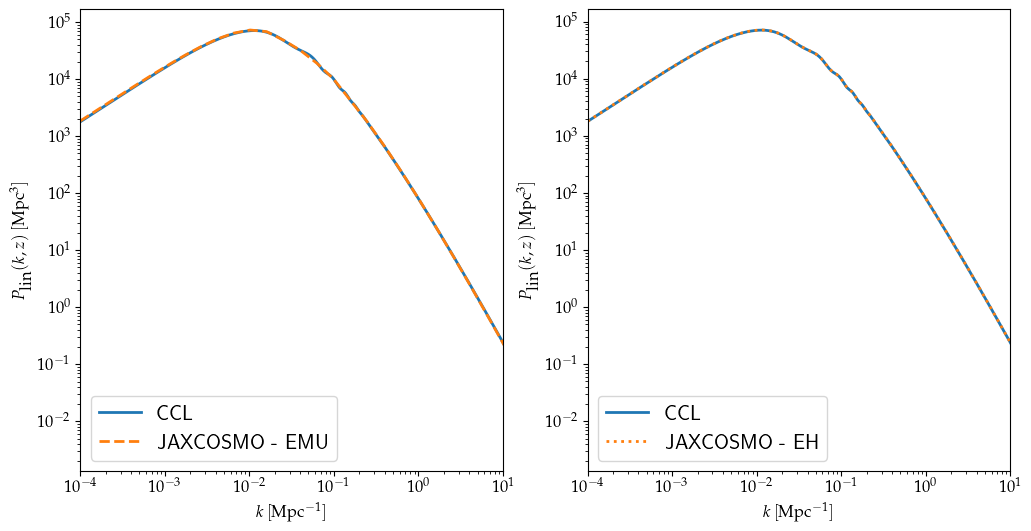

In [7]:
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(wavenumbers, pk_ccl, lw = 2, label = 'CCL')
plt.plot(wavenumbers, pk_jax_emu, lw = 2, linestyle = '--', label = 'JAXCOSMO - EMU')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{\textrm{lin}}(k,z)\,[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(wavenumbers), 10)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})

plt.subplot(122)
plt.plot(wavenumbers, pk_ccl, lw = 2, label = 'CCL')
plt.plot(wavenumbers, pk_jax_eh, lw = 2, linestyle = ':', label = 'JAXCOSMO - EH')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{\textrm{lin}}(k,z)\,[\textrm{Mpc}^{3}]$', fontsize = fontSize)
plt.xlabel(r'$k\,[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(wavenumbers), 10)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

## New Tracers

Implement a new Tracer and see how it compares with CCL.


In [8]:
from jax_cosmo.probes import CIBTracer

In [9]:
z_min = 0.0
z_max = 6.0
n_chi = 1024

## CIBTracer

$A=1$ and $\alpha = 1$


In [ ]:
ccl_tracer = ccl.CIBTracer(cosmo_ccl,
                           z_min = z_min,
                           z_max = z_max,
                           n_chi= n_chi)
w_ccl, chi_ccl = ccl_tracer.get_kernel()

jax_tracer = CIBTracer(z_min = z_min, z_max = z_max, n_z = n_chi)
w_jax, chi_jax = jax_tracer.kernel(cosmo_jax)

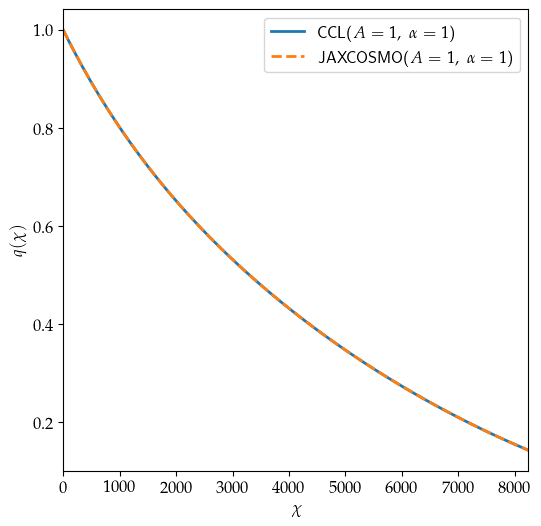

In [11]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl[0], w_ccl[0], lw = 2, label = 'CCL' + r'($A=1,\;\alpha=1$)')
plt.plot(chi_jax / cosmo_jax.h, w_jax, lw = 2, linestyle = '--', label = 'JAXCOSMO' + r'($A=1,\;\alpha=1$)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl[0]), max(chi_ccl[0]))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':12})
plt.show()

## Power From $z$

$A=1$ and $\alpha=2$


In [12]:
from jax_cosmo.probes import zPowerTracer

In [ ]:
ccl_tracer_power = ccl.tracers.Tracer.from_z_power(cosmo_ccl,
                           A = 1,
                           alpha = 2,
                           z_min = z_min,
                           z_max = z_max,
                           n_chi= n_chi)
w_ccl_power, chi_ccl_power = ccl_tracer_power.get_kernel()

In [14]:
jax_tracer_power = zPowerTracer(z_min = z_min, z_max = z_max, n_z = n_chi)
w_jax_power, chi_jax_power = jax_tracer_power.kernel(cosmo_jax, amplitude=1, alpha=2)

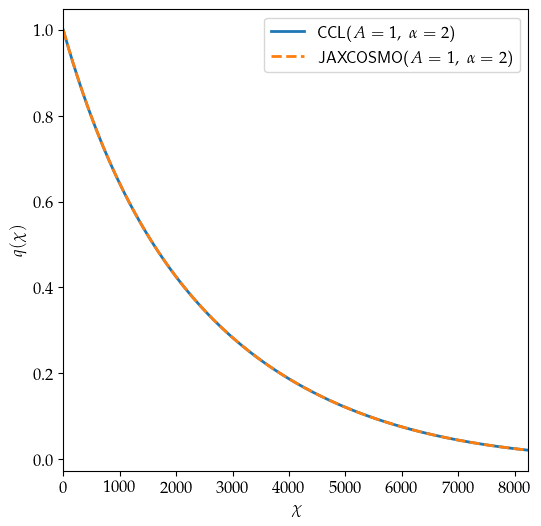

In [15]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl_power[0], w_ccl_power[0], lw = 2, label = 'CCL'+ r'($A=1,\;\alpha=2$)')
plt.plot(chi_jax_power / cosmo_jax.h, w_jax_power, lw = 2, linestyle = '--', label = 'JAXCOSMO' + r'($A=1,\;\alpha=2$)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl[0]), max(chi_ccl[0]))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':12})
plt.show()

## tSZTracer


In [16]:
from jax_cosmo.probes import tSZTracer

In [17]:
ccl_tSZ = ccl.tSZTracer(cosmo_ccl, z_max=z_max, n_chi=n_chi)
w_ccl_tSZ, chi_ccl_tSZ = ccl_tSZ.get_kernel()

In [18]:
jax_tracer_tSZ = tSZTracer(z_max = z_max, n_z = n_chi)
w_jax_tSZ, chi_jax_tSZ = jax_tracer_tSZ.kernel(cosmo_jax)

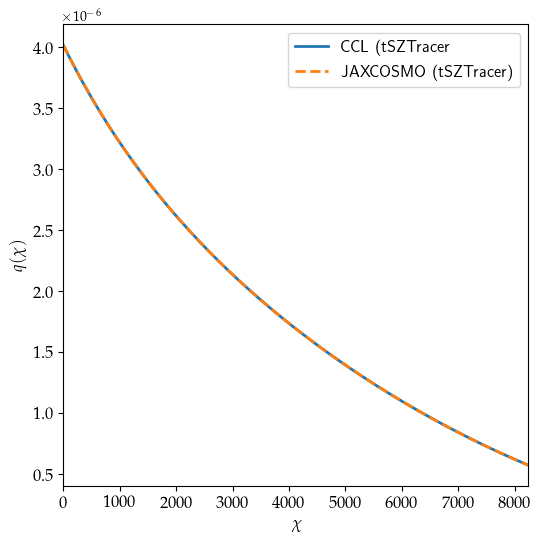

In [19]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl_tSZ [0], w_ccl_tSZ[0], lw = 2, label = 'CCL (tSZTracer')
plt.plot(chi_jax_tSZ / cosmo_jax.h, w_jax_tSZ, lw = 2, linestyle = '--', label = 'JAXCOSMO (tSZTracer)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl[0]), max(chi_ccl[0]))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':12})
plt.show()

## ISWTracer


In [20]:
from jax.tree_util import register_pytree_node_class
from jax_cosmo.jax_utils import container
import jax_cosmo.background as bkgrd
import jax_cosmo.cclconstants as cst

In [ ]:
def isw_kernel(cosmo, z_max: float, n_z: int) -> np.ndarray:
    a_arr, chi = bkgrd.scale_of_chi(cosmo, 0.0, z_max, n_z)
    H0 = cosmo.h / cst.CLIGHT_HMPC
    OM = cosmo.Omega_m
    Ez = bkgrd.H(cosmo, a_arr) / 100

    # this is a hack to get this working - need to understand the growth rate.
    fz = bkgrd.growth_rate(cosmo, a_arr)
    # fz = cosmo_ccl.growth_rate(a_arr)
    w_arr = 3 * cst.T_CMB * H0**3 * OM * Ez * chi**2 * (1-fz)
    return w_arr, chi

@register_pytree_node_class
class ISWTracer(container):
    """Class representing the Tracer associated with the integrated Sachs-Wolfe effect (ISW)

    z_max (float, optional): The maximim redshift. Defaults to 6.0.
    n_z (int, optional): The number of redshifts. Defaults to 1024.
    """

    def __init__(self, z_max=6.0, n_z=1024):
        super(ISWTracer, self).__init__(z_max, n_z)

    @property
    def zmax(self) -> float:
        """Returns the maximum redsfhit probed by this probe

        Returns:
            float: maximum redshift
        """
        return self.params[0]

    @property
    def n_z(self) -> int:
        """Returns the number of redshifts

        Returns:
            int: number of redshifts
        """
        return self.params[1]

    def kernel(self, cosmo: Cosmology) -> np.ndarray:
        """Calculates the cosmic infrared background kernel.

        Args:
            cosmo (Cosmology): the cosmology object in JAX COSMO

        Returns:
            np.ndarray: the ISW kernel.
        """
        inputs = {
            "z_max": self.params[0],
            "n_z": self.params[1],
        }
        return isw_kernel(cosmo, **inputs)

In [22]:
z_max = 6
n_z = 1000

In [23]:
jax_tracer_ISW = ISWTracer(z_max = z_max, n_z = n_chi)
w_jax_ISW, chi_jax_ISW = jax_tracer_ISW.kernel(cosmo_jax)

In [24]:
ccl_ISW_Tracer = ccl.ISWTracer(cosmo_ccl, z_max=z_max, n_chi=n_chi)
w_ccl_ISW, chi_ccl_ISW = ccl_ISW_Tracer.get_kernel()

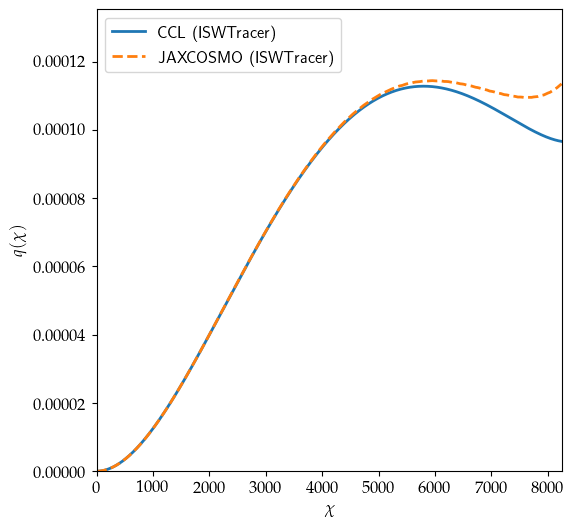

In [25]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl_ISW[0], w_ccl_ISW[0], lw = 2, label = 'CCL (ISWTracer)')
plt.plot(chi_jax_ISW / cosmo_jax.h, w_jax_ISW / cosmo_jax.h**2 , lw = 2, linestyle = '--', label = 'JAXCOSMO (ISWTracer)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl_ISW[0]), max(chi_ccl_ISW[0]))
plt.ylim(0.0,  1.2*max([max(w_ccl_ISW[0]), max(w_jax_ISW)]))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':12})
plt.show()

## CMB Lensing Kernel

<!-- <center>
    <img src="reference/cmb_lensing.png" alt="Image" style="width: 50%; height: auto;" />
</center>
 -->


In [26]:
from jax_cosmo.probes import CMBLensingTracer
from typing import Tuple
from jax_cosmo.core import Cosmology
import jax_cosmo.constants as const
from jax_cosmo.utils import z2a

In [27]:
z_source = 1100
n_samples = 100

In [28]:
jax_tracer_CMB = CMBLensingTracer(z_source = z_source, n_samples=n_samples)
w_jax_CMB, chi_jax_CMB = jax_tracer_CMB.kernel(cosmo_jax)

In [29]:
ccl_CMB_Tracer = ccl.CMBLensingTracer(cosmo_ccl, z_source=z_source, n_samples=n_samples)
w_ccl_CMB, chi_ccl_CMB = ccl_CMB_Tracer.get_kernel()

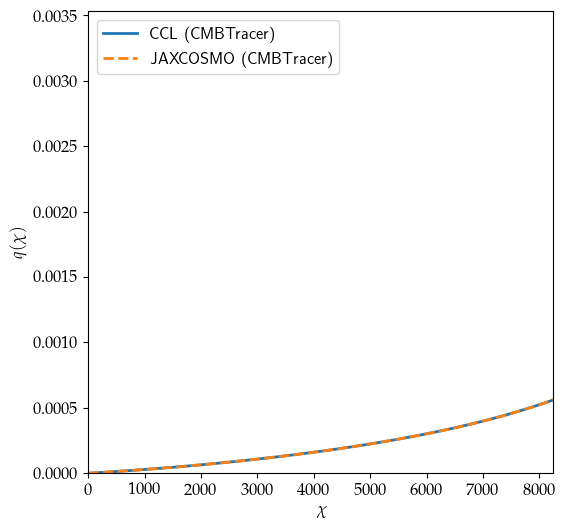

In [30]:
plt.figure(figsize = (6, 6))
plt.plot(chi_ccl_CMB[0], w_ccl_CMB[0], lw = 2, label = 'CCL (CMBTracer)')
plt.plot(chi_jax_CMB / cosmo_jax.h, w_jax_CMB / cosmo_jax.h, lw = 2, linestyle = '--', label = 'JAXCOSMO (CMBTracer)')
plt.ylabel(r'$q(\chi)$', fontsize = fontSize)
plt.xlabel(r'$\chi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(chi_ccl_ISW[0]), max(chi_ccl_ISW[0]))
plt.ylim(0.0, 1.2*max(w_ccl_CMB[0]))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':12})
plt.show()

### Distance Calculation

We have included the radiation term.


In [31]:
z_source = 1000
a_source = 1. / (1. + z_source)

In [32]:
ccl.background.comoving_radial_distance(cosmo_ccl, a = a_source)

13622.366045805722

In [33]:
bkgrd.radial_comoving_distance(cosmo_jax, a = a_source).item() / cosmo_jax.h

13622.396328179484

### Scalefactor of $\chi$


In [34]:
a_arr_jax, chi_arr_jax = bkgrd.scale_of_chi(cosmo_jax, 0.0, z_source, 500)

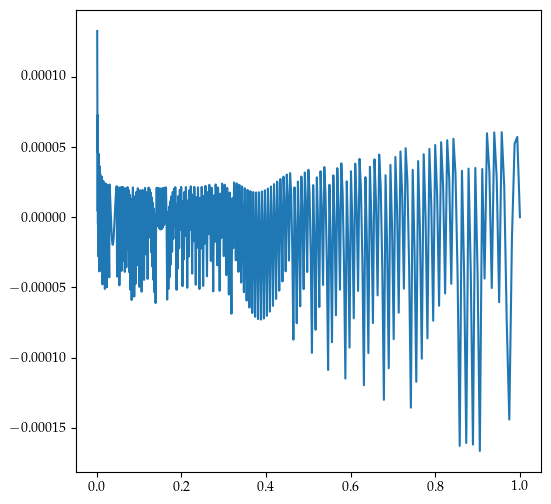

In [35]:
plt.figure(figsize = (6,6))
plt.plot(a_arr_jax, a_arr_jax / ccl.scale_factor_of_chi(cosmo_ccl, chi_arr_jax / cosmo_jax.h) - 1.0)
plt.show()

In [ ]:
z_min = 0
z_max = 1100
n_z = 50

a_min = z2a(z_min)
a_max = z2a(z_max)
chi_min = bkgrd.radial_comoving_distance(cosmo_jax, a=a_min)[0]
chi_max = bkgrd.radial_comoving_distance(cosmo_jax, a=a_max)[0]

redshifts = np.linspace(z_min, z_max, n_z)
scalefactors = z2a(redshifts)
chi_grid = bkgrd.radial_comoving_distance(cosmo_jax, scalefactors) / cosmo_jax.h

# we want the equivalent a_arr
chi_arr = np.linspace(chi_min, chi_max, n_z)

# jc implementation
a_arr_jax = bkgrd.a_of_chi(cosmo_jax, chi_arr )

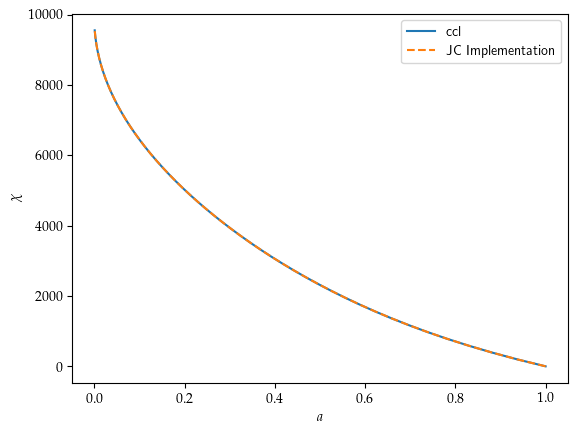

In [37]:
plt.plot(ccl.scale_factor_of_chi(cosmo_ccl, chi_arr / cosmo_jax.h), chi_arr, label = 'ccl')
plt.plot(a_arr_jax, chi_arr, linestyle = '--', label = 'JC Implementation')
plt.legend()
plt.ylabel(r'$\chi$')
plt.xlabel(r'$a$')
plt.show()

### Comoving Radial Distance


In [38]:
z_grid = np.linspace(0, 1100, 1000)
a_grid = 1. / (1 + z_grid)
ccl_dist = ccl.background.comoving_radial_distance(cosmo_ccl, a = a_grid)
jax_dist = bkgrd.radial_comoving_distance(cosmo_jax, a = a_grid) / cosmo_jax.h

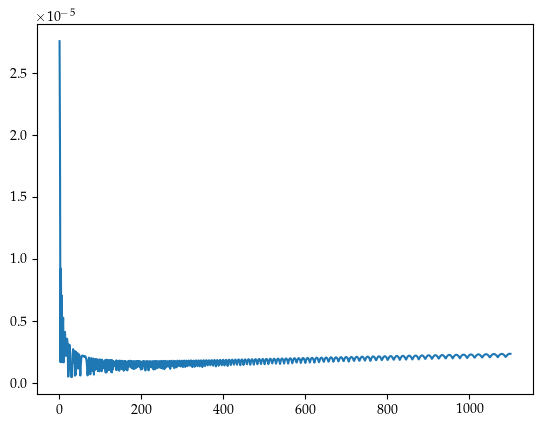

In [39]:
plt.plot(z_grid, jax_dist/ccl_dist - 1.0)
plt.show()

# Growth Rate and Growth Factor

The following is calculated directly from the JAX Cosmo implementation.


### Implementation of Differential Equations


In [3]:
from jax_cosmo.background import H, Omega_m_a
import jax_cosmo.background as bkgrd
from jax_cosmo.utils import a2z
from jax import grad

In [ ]:
def grad_H(cosmo, a):
    return grad(H, argnums=1)(cosmo, a)

def alpha_beta(cosmo, a):
    gH_over_H = grad_H(cosmo, a) / H(cosmo, a)
    alpha = 5. / a + gH_over_H
    beta = 3/a**2 + gH_over_H/a - 1.5 * Omega_m_a(cosmo, a)/a**2
    return jnp.array([[0.0, 1.0], [-beta, -alpha]])

def cash_karp_method(func, y0, t):

    def cash_karp(carry, t):
        y, t_prev = carry
        h = t - t_prev
        k1 = func(y, t_prev)
        k2 = func(y + h * k1 / 5, t_prev + 0.2*h)
        k3 = func(y + h * (3 * k1 / 40 +  9 * k2 / 40), t_prev + 0.3*h)
        k4 = func(y + h * (3 * k1 / 10 - 9 * k2 / 10 + 6 * k3 / 5), t_prev + 0.6*h)
        k5 = func(y + h * (-11 * k1 / 54 + 5 * k2 / 2 - 70 * k3 / 27 + 35 * k4 / 27), t_prev + h)
        k6 = func(y + h * (1631 * k1 / 55296 + 175 * k2 / 512 + 575 * k3 / 13824 + 44275 * k4 / 110592 + 253 * k5 / 4096), t_prev + 0.875*h)
        y = y + h * (37*k1/378 + 250*k3/621 + 125*k4/594 + 512*k6/1771)
        return (y, t), y
    (yf, _), y = jax.lax.scan(cash_karp, (y0, np.array(t[0])), t)
    return y

def euler_method(func, y0, t):

    def euler(carry, t):
        y, t_prev = carry
        h = t - t_prev
        k1 = func(y, t_prev)
        y = y + h * k1
        return (y, t), y

    (yf, _), y = jax.lax.scan(euler, (y0, np.array(t[0])), t)
    return y

In [ ]:
def growth_factor_calculation(cosmo, log10_amin=-3.1, steps=512, method = 'euler'):

    atab = np.logspace(log10_amin, 0.0, steps)
    y0 = np.array([1.0, atab[0]])

    def g_derivs(y, x):
        return alpha_beta(cosmo, x) @ y

    if method == 'euler':
        y_record = euler_method(g_derivs, y0, atab)
    elif method == 'cash-karp':
        y_record = cash_karp_method(g_derivs, y0, atab)

    # calculate growth rate
    growth_rate = (atab * y_record[:,1] / y_record[:,0]) + 1.0

    # calculate growth factor
    growth_factor = atab * y_record[:,0]
    growth_factor /= growth_factor[-1]

    return atab, growth_rate, growth_factor

In [13]:
A_MIN = -3.1
STEPS = 512

print(f"Maximum redshift is {a2z(10**A_MIN):.2f}")

Maximum redshift is 1257.93


In [ ]:
atab, gr_euler, gf_euler = growth_factor_calculation(cosmo_jax, log10_amin=A_MIN, steps=STEPS, method = 'euler')
atab, gr_ck, gf_ck = growth_factor_calculation(cosmo_jax, log10_amin=A_MIN, steps=STEPS, method = 'cash-karp')
gr_jax = bkgrd.growth_rate(cosmo_jax, atab)
gr_ccl = cosmo_ccl.growth_rate(atab)

gf_jax = bkgrd.growth_factor(cosmo_jax, atab)
gf_ccl = cosmo_ccl.growth_factor(atab)

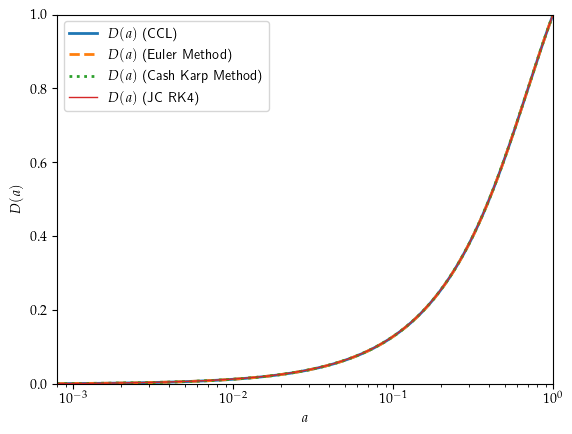

In [15]:
plt.plot(atab, gf_ccl, lw = 2, label = r'$D(a)$ (CCL)')
plt.plot(atab, gf_euler, lw = 2, linestyle = '--', label = r'$D(a)$ (Euler Method)')
plt.plot(atab, gf_ck, lw = 2, linestyle = ':', label = r'$D(a)$ (Cash Karp Method)')
plt.plot(atab, gf_jax, lw = 1, label = r'$D(a)$ (JC RK4)')
plt.xlabel(r'$a$')
plt.ylabel(r'$D(a)$')
plt.xscale('log')
plt.ylim(0, 1.0)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.show()

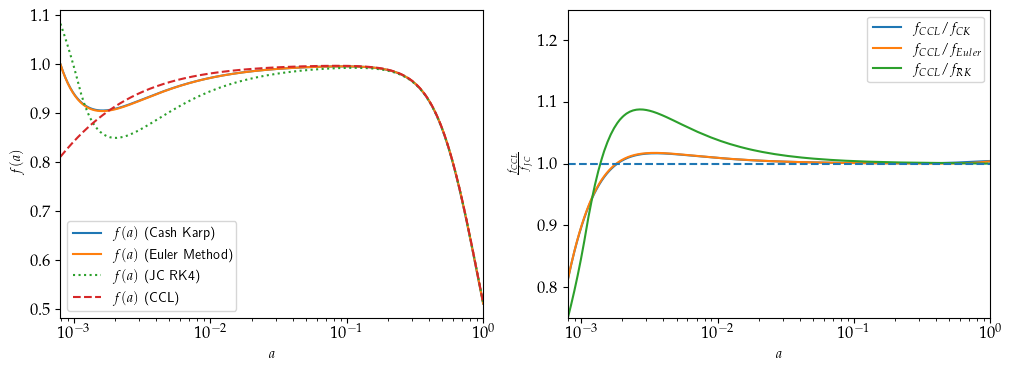

In [16]:
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(atab, gr_ck, label = '$f(a)$ (Cash Karp)')
plt.plot(atab, gr_euler, label = '$f(a)$ (Euler Method)')
plt.plot(atab, gr_jax, linestyle = ':', label = '$f(a)$ (JC RK4)')
plt.plot(atab, gr_ccl, linestyle = '--', label = '$f(a)$ (CCL)')
plt.xlabel(r'$a$')
plt.ylabel(r'$f(a)$')
plt.xscale('log')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.subplot(122)
plt.plot(atab, gr_ccl / gr_ck, label = '$f_{CCL}/f_{CK}$')
plt.plot(atab, gr_ccl / gr_euler, label = '$f_{CCL}/f_{Euler}$')
plt.plot(atab, gr_ccl / gr_jax, label = '$f_{CCL}/f_{RK}$')
plt.axhline(1, linestyle = '--')
plt.ylim(0.75, 1.25)
plt.xlabel(r'$a$')
plt.xscale('log')
plt.ylabel(r'$\frac{f_{CCL}}{f_{JC}}$')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.show()

# Transfer Function

In [10]:
from jax_cosmo.transfer import BBKS, Eisenstein_Hu
from jax_cosmo.power import linear_matter_power

In [11]:
kvalues = np.logspace(-4, 1, 100)

In [12]:
pklin_bbks = linear_matter_power(cosmo_jax, kvalues / cosmo_jax.h, a = 1.0, transfer_fn=BBKS) / cosmo_jax.h**3

cosmo_ccl_bbks = ccl.Cosmology(Omega_c=0.25,
                          Omega_b=0.05,
                          h=0.7,
                          sigma8 = 0.8,
                          n_s=0.96,
                          Neff = 3.044,
                          transfer_function='bbks')

pklin_ccl_bbks = cosmo_ccl_bbks.linear_matter_power(kvalues, a = 1.0)

In [13]:
pklin_eh = linear_matter_power(cosmo_jax,  kvalues / cosmo_jax.h, a = 1.0, transfer_fn=Eisenstein_Hu) / cosmo_jax.h**3

cosmo_ccl_eh = ccl.Cosmology(Omega_c=0.25,
                          Omega_b=0.05,
                          h=0.7,
                          sigma8 = 0.8,
                          n_s=0.96,
                          Neff = 3.044,
                          transfer_function='eisenstein_hu')

pklin_ccl_eh = cosmo_ccl_eh.linear_matter_power(kvalues, a = 1.0)

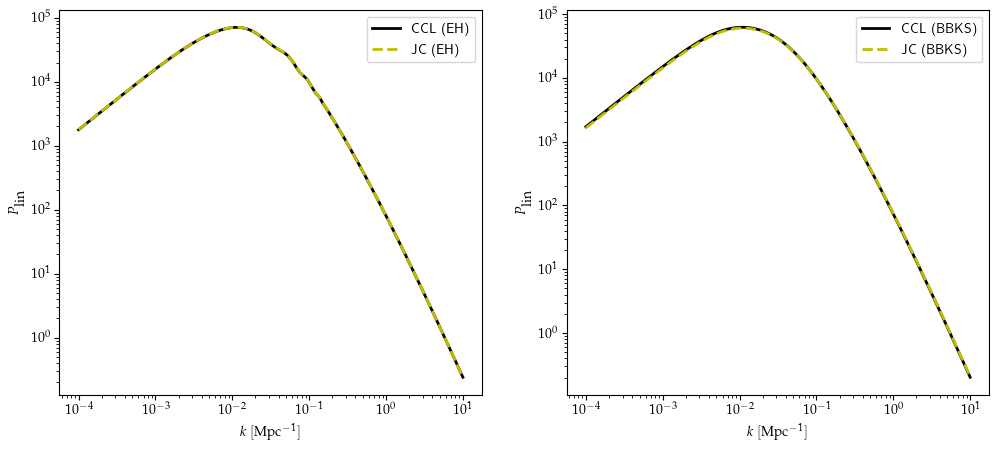

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(kvalues, pklin_ccl_eh, c = 'k', lw=2, label = 'CCL (EH)')
plt.plot(kvalues, pklin_eh , c = 'y', linestyle = '--', lw = 2, label = 'JC (EH)')
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$')
plt.ylabel(r'$P_{\textrm{lin}}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(kvalues, pklin_ccl_bbks, c = 'k', lw=2, label = 'CCL (BBKS)')
plt.plot(kvalues, pklin_bbks, c = 'y', lw=2, linestyle = '--', label = 'JC (BBKS)')
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$')
plt.ylabel(r'$P_{\textrm{lin}}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()